In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from centrex_tlf import couplings, hamiltonian, lindblad, states, transitions, utils
from labellines import labelLine, labelLines
from scipy.integrate import trapezoid

from centrex_tlf_julia_extension import lindblad_julia

c:\Users\Olivier\Documents\GitHub\CeNTREX-TlF-julia-extension\.venv\Lib\site-packages\juliacall\__init__.py:271: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
transition_params = [["R", 0, 3 / 2, 2]]


In [4]:
trans = []
for t, J, F1, F in transition_params:
    trans.append(
        transitions.OpticalTransition(
            getattr(transitions.OpticalTransitionType, t),
            J_ground=J,
            F1_excited=F1,
            F_excited=F,
        )
    )

In [5]:
polarizations = [[couplings.polarization_Z]] * len(trans)

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [6]:
# ignore small decay to J=6
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=True,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [7]:
odepars = lindblad_julia.odeParameters(
    Ω0=hamiltonian.Γ,
    δ0=0.0,  # detuning of the laser [rad/s]
    PZ0=1.0,
)

In [8]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars, n_procs=6
)

In [9]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F1 = 3/2, F = 2>"
states,
"|X, J = 0>",0.479672
"|X, J = 2>",0.520328


In [10]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F1 = 3/2, F = 2>"
states,
"|X, J = 0, F1 = 1/2, F = 1>",0.479672
"|X, J = 2, F1 = 3/2, F = 1>",0.011840
"|X, J = 2, F1 = 3/2, F = 2>",0.102845
"|X, J = 2, F1 = 5/2, F = 2>",0.028282
"|X, J = 2, F1 = 5/2, F = 3>",0.377361


In [11]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)

In [12]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=1, electronic=states.ElectronicState.B), obe_system.QN
)

In [13]:
odepars.Ω0 = 0.0

In [14]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 2e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [15]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 1.0


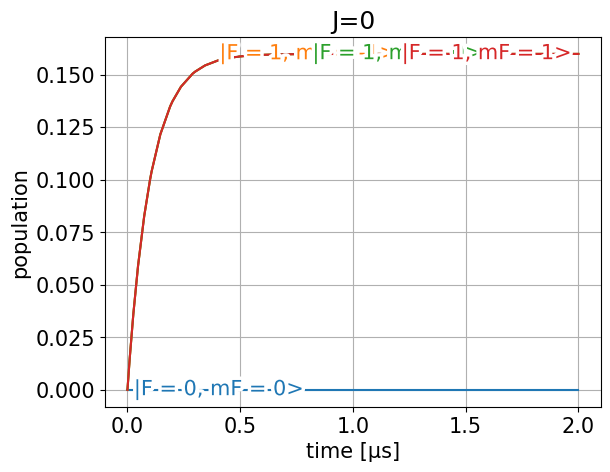

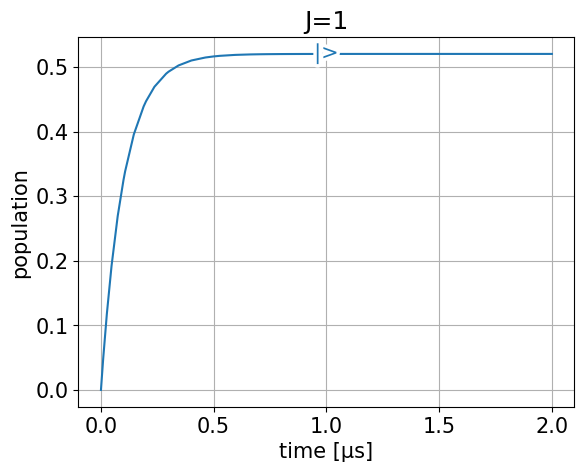

In [16]:
for J, ind in enumerate([indices_J0, indices_J2]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.1f}")


In [17]:
from scipy.optimize import curve_fit


def exp_fit(t, τ):
    return np.exp(-t / τ)


popt, pcov = curve_fit(
    exp_fit, results.t, results.y[indices_excited].sum(axis=0), p0=[1e-6]
)

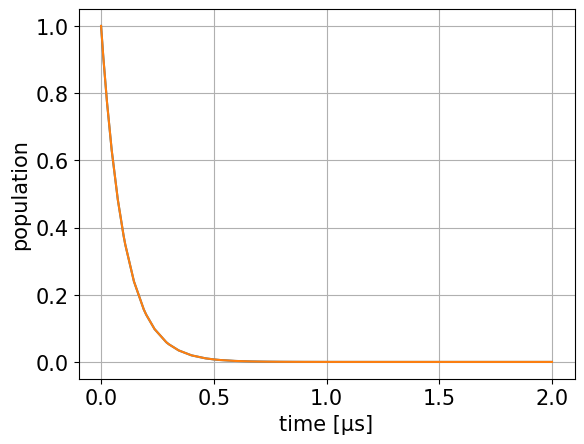

In [18]:
fig, ax = plt.subplots()

ax.plot(results.t * 1e6, results.y[indices_excited].sum(axis=0))
ax.plot(results.t * 1e6, exp_fit(results.t, *popt))

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

In [19]:
print(f"lifetime = {popt[0] * 1e9:.1f} ns")

lifetime = 102.0 ns


In [20]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, electronic=states.ElectronicState.X), obe_system.QN
)

In [21]:
odepars.Ω0 = 1 * hamiltonian.Γ

In [22]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [23]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 1.92


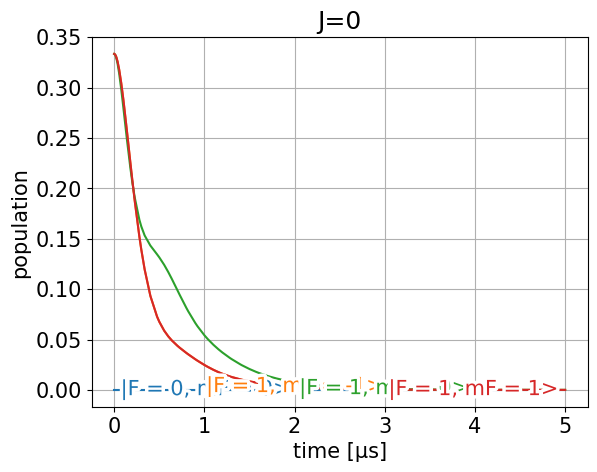

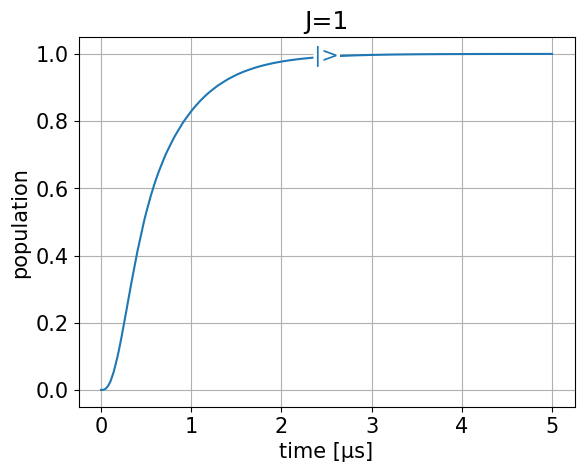

In [24]:
for J, ind in enumerate([indices_J0, indices_J2]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.2f}")


In [25]:
output_func = lindblad_julia.setup_state_integral_calculation(
    [6, 7, 8, 9, 10], nphotons=True
)
ens_prob = lindblad_julia.OBEEnsembleProblem(
    problem,
    parameters=["Ω0", "δ0"],
    scan_values=[
        np.linspace(1e-3, 3, 201) * 2 * np.pi * 1.56e6,
        np.linspace(-10, 10, 101) * 2 * np.pi * 1.56e6,
    ],
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ens_prob)

ens_config = lindblad_julia.OBEEnsembleProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [26]:
lindblad_julia.solve_problem_parameter_scan(ens_prob, ens_config)

In [27]:
scan_res = lindblad_julia.get_results_parameter_scan(ens_prob, ens_config)

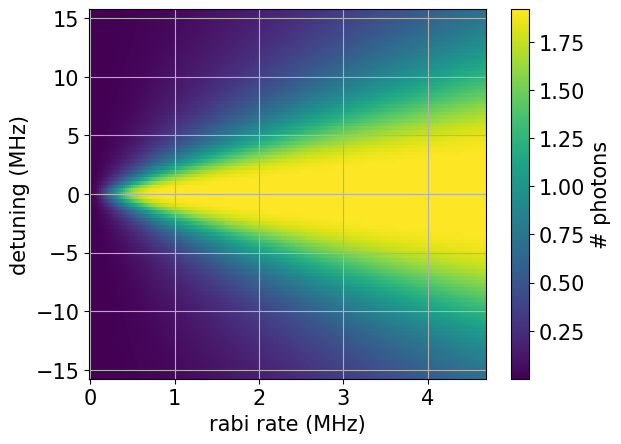

In [28]:
fig, ax = plt.subplots()
pmesh = ax.pcolormesh(
    *np.array(scan_res.scan_values) / (2 * np.pi * 1e6), scan_res.results
)

fig.colorbar(pmesh, label="# photons")

ax.set_xlabel("rabi rate (MHz)")
ax.set_ylabel("detuning (MHz)")

ax.grid()

In [29]:
from centrex_tlf_julia_extension.lindblad_julia.utils_julia import jl

julia_packages = ["BenchmarkTools"]
jl.seval("using Pkg")
for pkg in julia_packages:
    if not bool(jl.seval(f'isnothing(Base.find_package("{pkg}")) ? false : true')):
        print(f"Installing Julia package: {pkg}")
        jl.Pkg.add(pkg)
jl.seval("using BenchmarkTools")

In [30]:
_ = jl.seval("du = similar(ρ)")
_ = jl.seval("t = 0.0")

In [31]:
jl.seval("@benchmark Lindblad_rhs!(du, ρ, p, t)")

BenchmarkTools.Trial: 10000 samples with 803 evaluations per sample.
 Range (min … max):  158.655 ns … 903.362 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     163.636 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   176.493 ns ±  51.536 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██▂   ▁▂           ▂  ▂▂                                      ▂
  ███▇▇▆███▆▆▅▅▅▄▄▄▅▇█▇▄███▆▄▄▄▅▄▇▆▃▃▃▃▃▁▁▁▁▁▁▁▁▆▆▅▅▃▁▃▆▅▆▅▃▆▇█ █
  159 ns        Histogram: log(frequency) by time        458 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

# Matrix Method

In [32]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars, n_procs=6, method="matrix"
)

In [33]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=0, F=1, electronic=states.ElectronicState.X), obe_system.QN
)

In [34]:
odepars.Ω0 = 1 * hamiltonian.Γ

In [35]:
problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 5e-6))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [36]:
results = lindblad_julia.do_simulation_single(problem, config=config)

# photons = 1.92


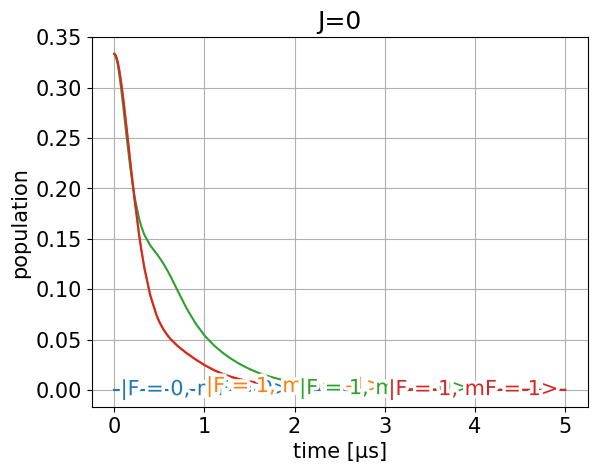

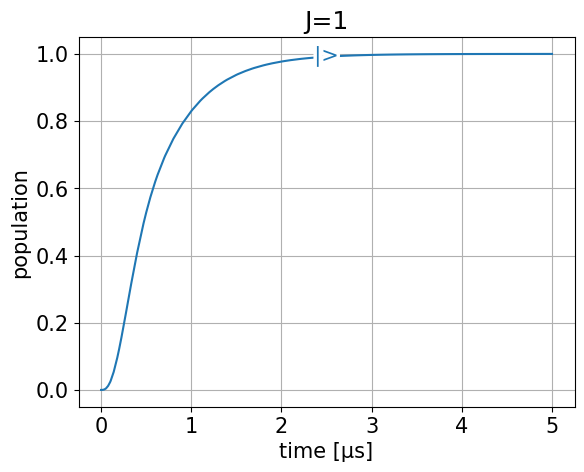

In [37]:
for J, ind in enumerate([indices_J0, indices_J2]):
    if len(ind) == 0:
        continue
    labels = [
        obe_system.QN[idx].largest.state_string_custom(["F", "mF"]) for idx in ind
    ]

    fig, ax = plt.subplots()
    ax.plot(results.t * 1e6, results.y[ind].T, label=labels)

    ax.set_title(f"J={J}")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("population")

    labelLines(ax.get_lines(), zorder=2.5, align=False)

    ax.grid()


photons = (
    trapezoid(results.y[indices_excited].sum(axis=0).real, x=results.t) * hamiltonian.Γ
)

print(f"# photons = {photons:.2f}")


In [38]:
output_func = lindblad_julia.setup_state_integral_calculation(
    [6, 7, 8, 9, 10], nphotons=True
)
ens_prob = lindblad_julia.OBEEnsembleProblem(
    problem,
    parameters=["Ω0", "δ0"],
    scan_values=[
        np.linspace(1e-3, 3, 201) * 2 * np.pi * 1.56e6,
        np.linspace(-10, 10, 101) * 2 * np.pi * 1.56e6,
    ],
    output_func=output_func,
)

lindblad_julia.setup_problem_parameter_scan(ens_prob)

ens_config = lindblad_julia.OBEEnsembleProblemConfig(
    saveat=1e-7, reltol=1e-4, abstol=1e-7, save_everystep=True, callback=None
)

In [39]:
lindblad_julia.solve_problem_parameter_scan(ens_prob, ens_config)

In [40]:
scan_res = lindblad_julia.get_results_parameter_scan(ens_prob, ens_config)

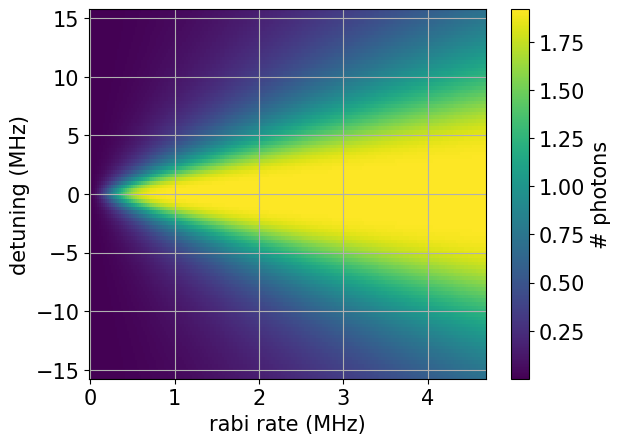

In [41]:
fig, ax = plt.subplots()
pmesh = ax.pcolormesh(
    *np.array(scan_res.scan_values) / (2 * np.pi * 1e6), scan_res.results
)

fig.colorbar(pmesh, label="# photons")

ax.set_xlabel("rabi rate (MHz)")
ax.set_ylabel("detuning (MHz)")

ax.grid()

In [42]:
jl.seval("@benchmark Lindblad_rhs!(du, ρ, p, t)")

BenchmarkTools.Trial: 10000 samples with 10 evaluations per sample.
 Range (min … max):  1.170 μs …   7.210 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.180 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.220 μs ± 194.341 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▇ ▁▁                                                       ▂
  █████▆▆▅▄▅▅▃▄▅▁▃▄▄▄▄▃▄▅▅▅▄▁▄▄▃▇▆▅▅▆▅▆▇▅▇▇▅▆▇▆▇▆▅▆▆▄▆▅▅▄▅▅▆▅ █
  1.17 μs      Histogram: log(frequency) by time      2.15 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.